`KDD2024 Tutorial / A Hands-On Introduction to Time Series Classification and Regression`

# Shapelet-based Time Series Machine Learning in `aeon`

In this notebook, our goal is to introduce the use of shapelets for time series
machine learning. We provide examples on how to use shapelet-based transformations, classification and regression estimators with the two KDD examples datasets. We also show how to use the visualization tools associated with these estimators.

In [ ]:
!pip install aeon==0.11.0
!mkdir -p data
!wget -nc https://raw.githubusercontent.com/aeon-tutorials/KDD-2024/main/Notebooks/data/KDD_MTSC_TRAIN.ts -P data/
!wget -nc https://raw.githubusercontent.com/aeon-tutorials/KDD-2024/main/Notebooks/data/KDD_MTSC_TEST.ts -P data/
!wget -nc https://raw.githubusercontent.com/aeon-tutorials/KDD-2024/main/Notebooks/data/KDD_UTSC_TRAIN.ts -P data/
!wget -nc https://raw.githubusercontent.com/aeon-tutorials/KDD-2024/main/Notebooks/data/KDD_UTSC_TEST.ts -P data/
!wget -nc https://raw.githubusercontent.com/aeon-tutorials/KDD-2024/main/Notebooks/data/KDD_MTSER_TRAIN.ts -P data/
!wget -nc https://raw.githubusercontent.com/aeon-tutorials/KDD-2024/main/Notebooks/data/KDD_MTSER_TEST.ts -P data/
!wget -nc https://raw.githubusercontent.com/aeon-tutorials/KDD-2024/main/Notebooks/data/KDD_UTSER_TRAIN.ts -P data/
!wget -nc https://raw.githubusercontent.com/aeon-tutorials/KDD-2024/main/Notebooks/data/KDD_UTSER_TEST.ts -P data/

In [1]:
# There are some deprecation warnings present in the notebook, we will ignore them.
# Remove this cell if you are interested in finding out what is changing soon, for
# aeon there will be big changes in out v1.0.0 release!
import warnings

warnings.filterwarnings("ignore", category=FutureWarning)


Let's us first make some imports and load the datasets (this can take some time if this is the first time you import these !):

In [2]:
import numpy as np
from aeon.datasets import load_classification
from aeon.transformations.collection.shapelet_based import (
    RandomShapeletTransform,
)
from aeon.classification.shapelet_based import (
    ShapeletTransformClassifier,
    RDSTClassifier,
)
from aeon.testing.data_generation import make_example_3d_numpy

As most of the estimators we imported make use of `numba`, the first call to `fit/predict` methods will take some time to compile the functions and cache them. To make this compilation faster, for the first time you call these on your system, you can call them on a dummy dataset with a specific parameter set (this can take ~1-2min) :

In [3]:
X = make_example_3d_numpy(return_y=False, n_cases=5)
y = np.array([0, 1, 0, 1, 0])
for classifier in [
    ShapeletTransformClassifier,
    RDSTClassifier,
]:
    print(f"Compiling {classifier.__name__}")
    classifier(**classifier.get_test_params()).fit(X, y).predict(X)

Compiling ShapeletTransformClassifier
Compiling RDSTClassifier


You can execute the above cell again and see that it's now instant ! (Note that `RDST` has a `distance` parameter, which, if modified, will trigger a new compilation step). Now, we load the example dataset :

In [4]:
# The original scale of the dataset is extremely small ! (~1e-5).
# to avoid issues with some computational methods, we standardize it
# to obtain a reasonable scale
X_train, y_train = load_classification("KDD_UTSC", split="TRAIN")
X_test, y_test = load_classification("KDD_UTSC", split="TEST")

# Shapelet-based time series machine learning

The shapelet-based (classification) framework is summarized in the image below:

<img src="img/shp_general.png" alt="drawing" width="700"/>

First the $k$ shapelets are generated using the training data (with $k$ a parameter), then, by performing the Shapelet Transform with the generated shapelets and some time series dataset with $n$ samples, we obtain a feature matrix of size $(n,k)$, this matrix is then used by a tabular classifier, such as each sample is described by $k$ features obtained by using the shapelets.

This step shapelet generation and feature extraction can be made using estimators in `aeon.transformation.collection.shapelet_based`, for example, using the `RandomShapeletTransform`:

In [5]:
rst = RandomShapeletTransform().fit(
    X_train, y_train
)
X_T = rst.transform(X_test)
print(X_test.shape)
print(X_T.shape)

(40, 1, 100)
(40, 72)


## What features are extracted using shapelets ?

Features extracted using shapelets are extracted from a distance vector, which stores the distance between the shapelet $S$ (of size $l$) and every subsequence of the same size in a time series $X$.  For example, `RandomShapeletTransform` extracts the minimum from this distance vector. More formally, using the Euclidean distance :

$\displaystyle{\min\limits_{i\ :1, \ldots, m-l+1} \sqrt{\sum_{j=0}^{l-1}(\mathbf{s}_j - \mathbf{x}_{i+j})^2}}$

This represents the core idea that the distance of a shapelet to a time series is defined as the distance between the shapelet and the best matching subsequence of the same size in $X$. We can illustrate this formula with the following image, where we would extract the minimum from the values $v$ :

<img src="img/ex_shp_simple.png" alt="drawing" width="500"/>

(A bit off topic, but such distance vector can be computed efficiently using the `QuerySearch` estimator in the `similarity_search` module, using the shapelet as query.)

Note that, other estimators, such as `RandomDilatedShapeletTransform`, the size of the feature matrix is actually $(n, 3k)$, as 3 features are extracted from each shapelets :

- $\text{argmin} V$ : the location of the best match, where the location is the position of the front of the shapelet
- $\sum_i I(v_i < \lambda)$ : the shapelet occurence feature, which counts how many times $S$ was $\lambda$-close to $X$ (with $I$ the identity function).

Adding more features allows shapelets to be discriminative with respect to more criterions (number of $\lambda-close$ matches, location of best match) than only the best match distance

Another interesting notion is how shapelets are generated from the input time series. For now, just know that either an exhausitve search considering all possible candidate is made, or this search is approximated using heuristics, or random approaches. It is also possible to learn shapelets, which is the approach taken by `LearningShapeletClassifier`.

# Shapelets for classification (or regression)

Now that we understand the basics, we can start using the shapelet-based classifiers, such as `ShapeletTransformClassifier` (or `RDSTRegressor` for regression). The `fit` method will extract shapelets, perform the transformation of the training data, and by default, train a `RotationForestClassifier` classifier on the transformed data. You can choose which classifier you want to use, either by using the `estimator` parameter, or by building a pipeline yourself from a transformation. For example, with a `RidgeClassifierCV` estimator :

In [6]:
from sklearn.linear_model import RidgeClassifierCV

stc = ShapeletTransformClassifier(estimator=RidgeClassifierCV(), max_shapelet_length=33).fit(
    X_train, y_train
)
print(f"Accuracy : {stc.score(X_test, y_test)}")

Accuracy : 0.625


We can visualize shapelet-based classifiers using the `ShapeletClassifierVisualizer` class, which expose methods to plot the generated shapelets, the distance vectors, the feature they produce, and how they match the data. When possible (based on the type of classifier), we can also plot the best shapelets based on a criterions of feature importance from the fitted classifier. For example with the `ShapeletTransformClassifier` we just used (scatter plots can get messy with long shapelets !) :

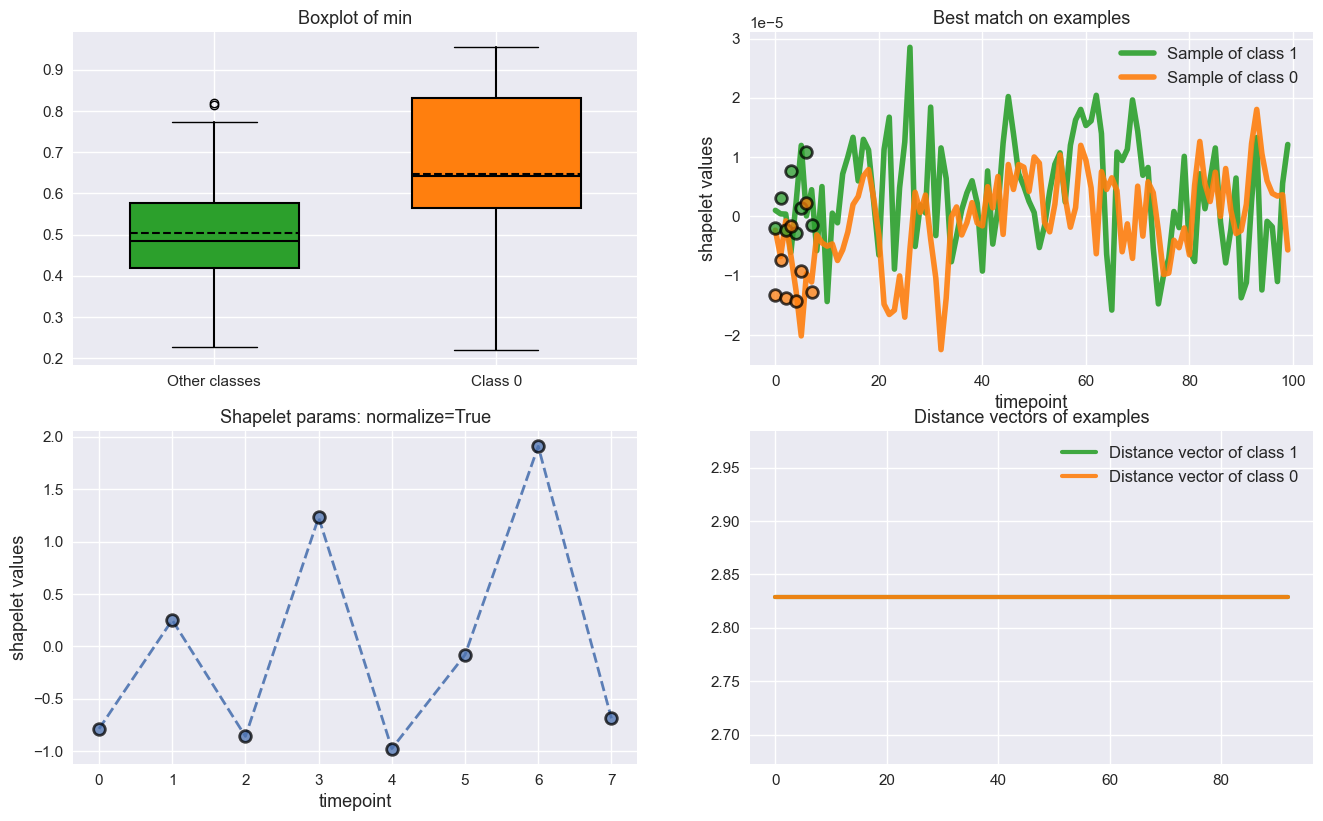

In [7]:
from aeon.visualisation import ShapeletClassifierVisualizer

stc_vis = ShapeletClassifierVisualizer(stc)
id_class = 0 # Show the best shapelet for class 0
fig = stc_vis.visualize_shapelets_one_class(
    X_test,
    y_test,
    id_class,
    figure_options={"figsize": (16,9.5), "nrows": 2, "ncols": 2}, # Some options to make a beatiful plot
    scatter_options={"s": 70,"alpha": 0.75,"zorder": 3,"edgecolor": "black","linewidths": 2}, # Some options to make a beatiful plot
    rc_Params_options={  # Some options to make a beatiful plot
    "legend.fontsize": 12,
    "xtick.labelsize": 11,
    "ytick.labelsize": 11,
    "axes.titlesize": 13,
    "axes.labelsize": 13,
},
)

The four graphs each aid in the interpretability of shapelet-based algorithms. Here we take the most discriminating shapelet of class 0 and explore it for both local and global patterns.

- Boxplot of Min (Top Left): This graph introduces a new perspective by focusing on a global quality of the shapelet. It shows the distribution of the minimum distances between the shapelet and each time series across different classes. As expected, the shapelet fits class 0 more closely than the other classes.

- Best Match on Examples (Top Right): This graph extends the best match visualization by showing how the shapelet fits a random time series from each class. The green and orange curves represent samples from classes 1 and 0, respectively. The shapelet should, and does, align more closely with the organge time series of class 0, illustrating its effectiveness in distinguishing between the two classes according to a local pattern.

- Shapelet Params (Bottom Left): This graph, already introduced, elegantly displays the shapelet's pattern over time.

- Distance Vectors of Examples (Bottom Right): This graph is an extension of the distance vector visualization, offering a comparison of how well the shapelet fits the two time series, from the 'Best Match on Examples' graph, at each point. This allows for a global understanding of how well the shapelet fits a time series at any point.

We can try to use `RDSTClassifier`, which use the notion of dilation for shapelets, and also extract 2 more features :

Accuracy : 0.95


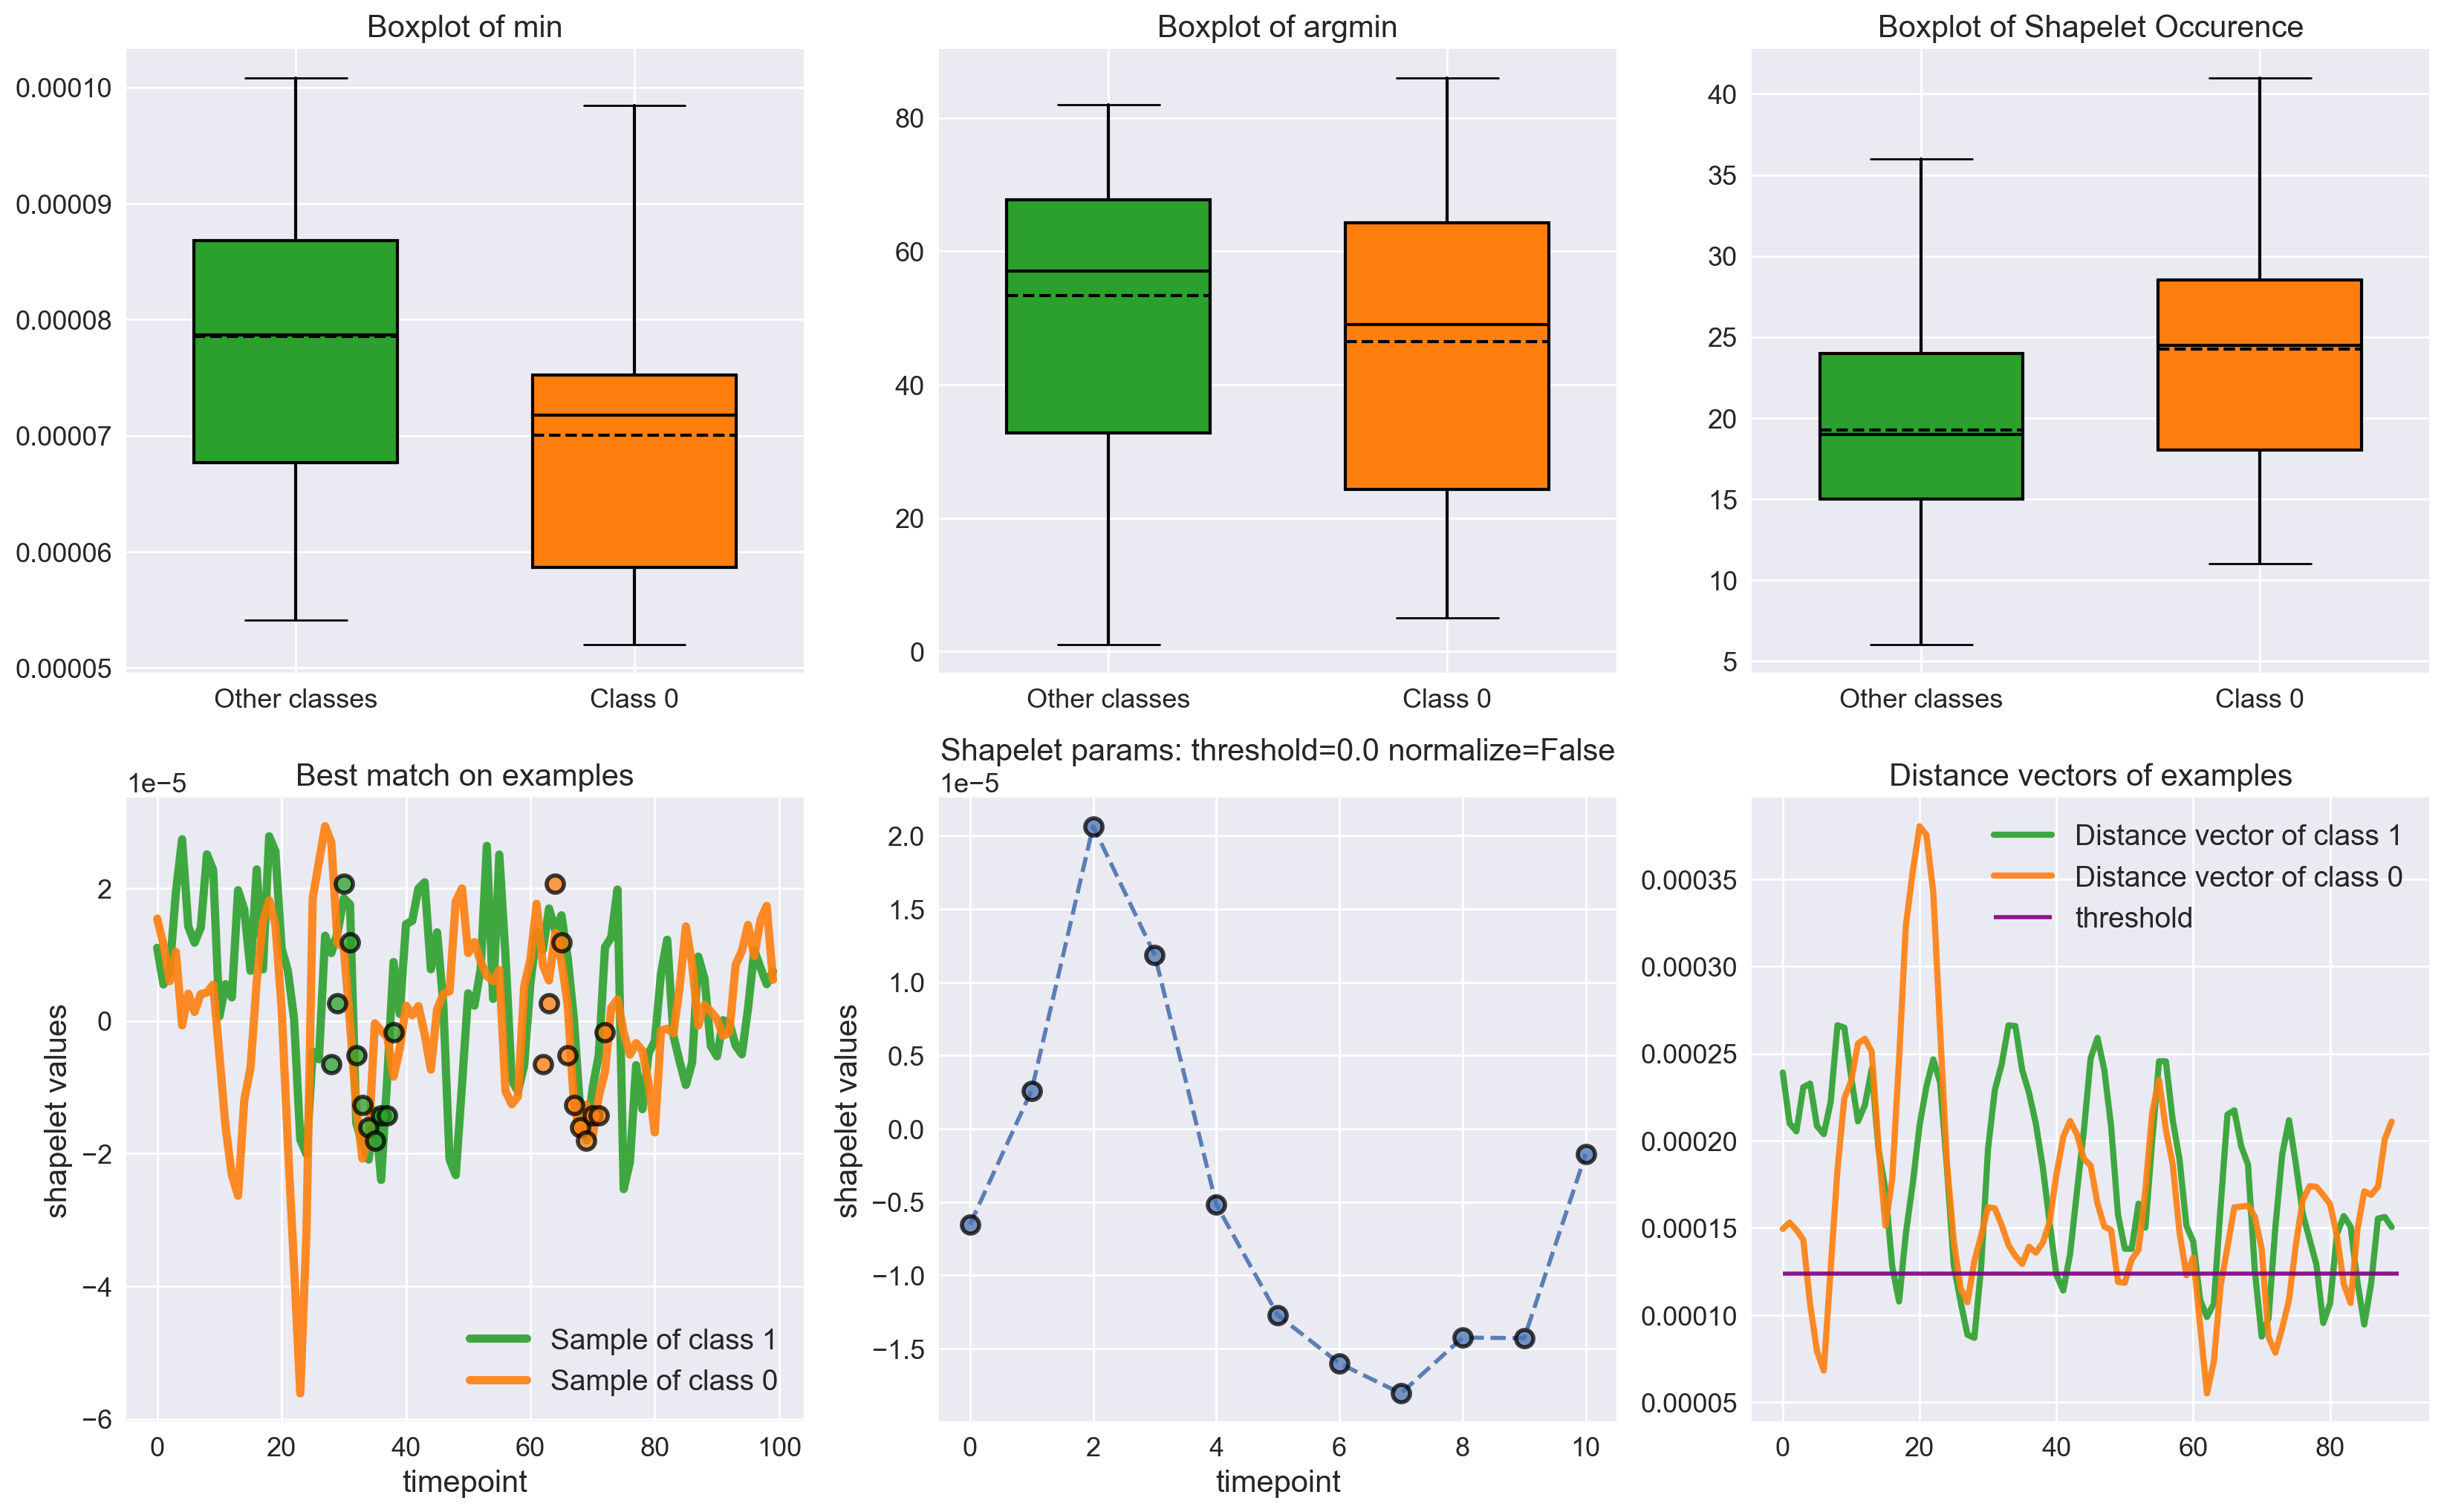

In [8]:
rdst = RDSTClassifier().fit(
    X_train, y_train
)
print(f"Accuracy : {rdst.score(X_test, y_test)}")

rdst_vis = ShapeletClassifierVisualizer(rdst)
id_class = 0 # Best shapelet for class 0
fig = rdst_vis.visualize_shapelets_one_class(
    X_test,
    y_test,
    id_class,
    scatter_options={"s": 70,"alpha": 0.75,"zorder": 3,"edgecolor": "black","linewidths": 2},
)

Many parameters are available to parallelize or tune these estimators, **which support both multivariate and unequal length time series**, we advise you to take a look at the documentation of `aeon` for a deeper dive in shapelets !.

## Results on TSC benchmark

(<Figure size 600x230 with 1 Axes>, <Axes: >)

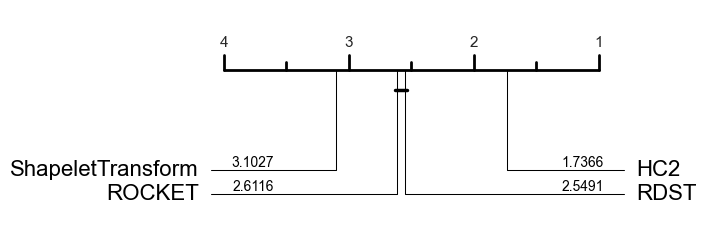

In [9]:
from aeon.benchmarking import get_estimator_results_as_array
from aeon.datasets.tsc_datasets import univariate

est = ["ROCKETClassifier", "RDSTClassifier", "ShapeletTransformClassifier", "HC2"]
names = [t.replace("Classifier", "") for t in est]
results, present_names = get_estimator_results_as_array(
    names, univariate, include_missing=False
)

from aeon.visualisation import plot_critical_difference

plot_critical_difference(results, names)

To compare the performance of shapelet to the other SotA method, we compare `RDSTClassifier` and `ShapeletTransformClassifier` to `Rocket` and `HC2`. Notice how `RDST`and `ROCKET` are considered equivalent, which is not surprising as `RDST` shares many similarities with `ROCKET`.

## References <a id='references'></a>

[1]  J. Lines, LM Davis, J Hills, A Bagnall, A shapelet transform for time series
classification, Proceedings of the 18th ACM SIGKDD international conference on
Knowledge, 2012
[2] J Hills, J Lines, E Baranauskas, J Mapp, A Bagnall, Classification of time series
by shapelet transformation, Data mining and knowledge discovery 28, 851-881, 2014
[3]
